In [1]:
# Testing GARCH model to compare to LSTM

In [ ]:
from arch import arch_model
import numpy as np
import pandas as pd

from net.parse import get_data
from net import MAPE, RMSE

In [9]:
df = get_data()

/Users/tudor/CS-Work/ML/P3/VFNN/src/net/parse/finance_parser.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  daily = yf.download(tickers='^SPX', start=start, end=end, interval='1d')
[*********************100%***********************]  1 of 1 completed


In [ ]:
retr = df['returns'] / 1e6
vol = df['volatility'] / 1e6
# Reset Scale

In [15]:
b1 = int(len(retr) * 0.8)
train, test = retr[:b1], retr[b1:]
vol_test = vol[b1:]

In [16]:
def garch_forecast_rolling(train_returns: pd.Series, test_returns: pd.Series, window: int = 300, horizon: int = 3) -> list:
    preds = []
    full_returns = pd.concat([train_returns, test_returns])
    train_len = len(train_returns)

    for i in range(len(test_returns) - horizon):
        # Rolling training window (can also use full train + i test samples if preferred)
        window_data = full_returns[train_len + i - window : train_len + i]

        model = arch_model(window_data, vol='Garch', p=1, q=1)
        res = model.fit(disp='off')

        # Forecast h-step ahead variance
        forecast = res.forecast(horizon=horizon, reindex=False)
        var_forecast = forecast.variance.values[-1]  # shape: (horizon,)
        
        # Combine h-day variance into single volatility estimate
        sigma_3day = np.sqrt(np.sum(var_forecast))  # like your LSTM target
        preds.append(sigma_3day)

    return preds


In [25]:
garch_preds = garch_forecast_rolling(train, test, window=300, horizon=3)
targs = test[3:]

In [33]:
import torch

In [34]:
nd_targs = torch.tensor(np.array(targs))
nd_preds = torch.tensor(np.array(garch_preds))

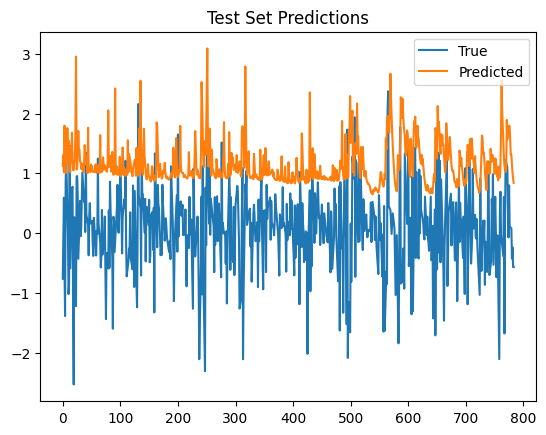

In [37]:
from matplotlib import pyplot as plt
plt.plot(nd_targs, label='True')
plt.plot(nd_preds, label='Predicted')
plt.title("Test Set Predictions")
plt.legend()